<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Model_StateFarm_DistractedDriver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinando Modelo do Desafio de Detecção de Distração do Motorista

## Importando bibliotecas

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, pathlib, glob, sys

IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = os.environ.get('PWD') == '/kaggle/working'

%matplotlib inline
plt.style.use('ggplot')

### Importando o Tensorflow

In [0]:
# importando a biblioteca tensorflow
import tensorflow as tf

# Definindo sementes aleatória  (para facilitar a 
# repetibilidade do código)
tf.random.set_seed(0)
np.random.seed(0)

#verificando a versão do tensorflow
tf.__version__

'2.1.0'

In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'state-farm-distracted-driver-detection'
root_output_local = f'{competition_name}/model' if not IN_COLAB and not IN_KAGGLE else ''
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [0]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

## Obtendo os dados do desafio

In [0]:
from zipfile import ZipFile

def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    if not os.path.exists(api_local_credential_location):
        !mkdir -p ~/.kaggle
        !cp '{api_location}' '{api_local_credential_location}'

def get_kaggle_data_competition(competition_name, gdrive_kaggle_dir=None):
    if IN_COLAB and not os.path.exists(competition_name):
        gdrive_competition_path = os.path.join(gdrive_kaggle_dir, competition_name)
        if os.path.exists(gdrive_competition_path):
            print('Copiando dados do Google Drive')
            !cp -r '{gdrive_competition_path}' .

    if not os.path.exists(competition_name):
        # Instalação do pacote para acesso a API do Kaggle
        !pip -q install kaggle --upgrade
        # Download dos dados da competição
        !kaggle competitions download -c {competition_name} -p {competition_name}
        if IN_COLAB and os.path.exists(gdrive_kaggle_dir):
            !cp -r {competition_name} '{gdrive_kaggle_dir}'

def extract_files(competition_name):
    if IN_COLAB and os.path.exists(os.path.join(competition_name, f'{competition_name}.zip')):
        with ZipFile(os.path.join(competition_name, f'{competition_name}.zip'), 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall(competition_name)
        os.remove(os.path.join(competition_name, f'{competition_name}.zip'))

In [0]:
# Obtem os dados somente se o notebook não esteja sendo executado no Kaggle
if not IN_KAGGLE: 
    get_kaggle_json(api_gdrive_credential_location)
    get_kaggle_data_competition(competition_name, gdrive_kaggle_dir)
    extract_files(competition_name)

In [0]:
pre_dir = '/kaggle/input' if IN_KAGGLE else ''
data_dir = os.path.join(pre_dir, competition_name, 'imgs')
test_dir = f'{data_dir}/test/'
train_dir = f'{data_dir}/train/'

## Analisando Distribuição das Imagens

In [0]:
# Obtendo os diretórios de imagens e a quantidade existente em cada
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*.jpg')))
print(f'Train size: {train_image_count} | Test size: {test_image_count}')

Train size: 22424 | Test size: 79726


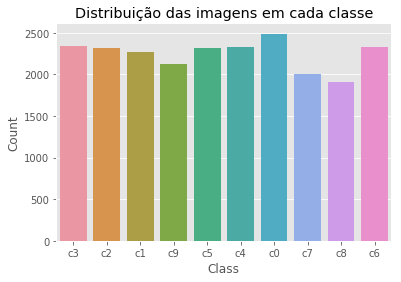

In [0]:
sns.barplot(x='Class', y='Count', data=pd.DataFrame.from_dict(
    {dir: [len(glob.glob(os.path.join(train_data_dir, dir, '*.jpg')))] for dir in os.listdir(train_data_dir)}, 
    orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Class'})).set_title('Distribuição das imagens em cada classe');

## Configurando TPU

In [0]:
# Detectando TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: # Se Não tiver TPU disponível
    tpu = None
    
# Seleciona estratégia
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Executando na TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
    strategy = tf.distribute.get_strategy() # Estratégia padrão que funciona com GPU ou CPU
    if len(tf.config.experimental.list_physical_devices('GPU')) or len(tf.config.experimental.list_physical_devices('XLA_GPU')):
        print("GPUs Disponíveis: ", len(tf.config.experimental.list_physical_devices('GPU')) + len(tf.config.experimental.list_physical_devices('XLA_GPU')))
    else:
        print('Executando no CPU')
print("Número de Aceleradores: ", strategy.num_replicas_in_sync)

GPUs Disponíveis:  2
Número de Aceleradores:  1


## Configurando DataSets

In [0]:
# Obtendo nomes das classes
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['c3', 'c2', 'c1', 'c9', 'c5', 'c4', 'c0', 'c7', 'c8', 'c6'],
      dtype='<U2')

In [0]:
# Criando geradores para o pré-processamento
train_valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [0]:
# Definindo parâmetros para o treinamento e processamento das imagens
BATCH_SIZE = 256
if tpu:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [0]:
# Carregando os geradores com base no caminho para o diretório de imagens
train_data_gen = train_valid_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    subset='training')
validation_data_gen = train_valid_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [0]:
validation_no_shuffe = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='validation')

Found 4481 images belonging to 10 classes.


In [0]:
# Carregando os geradores com base no caminho para o diretório de imagens
test_data_gen = test_generator.flow_from_directory(
    directory=str(data_dir), 
    classes=['test'], 
    class_mode=None, 
    shuffle=False, 
    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 79726 images belonging to 1 classes.


## Visualizando amostra das imagens de treinamento

In [0]:
def show_batch(image_batch, label_batch=None,predict_labels=None):
    """Mostra um lote de 25 imagens (e sua classificação caso exista)"""
    plt.figure(figsize=(10,10))
    for n in range(25):
        # Define o subplot para exibição da imagem
        ax = plt.subplot(5,5,n+1)
        # Plota a imagem
        plt.imshow(image_batch[n])
        
        # Configura o titulo (indica se a previsão foi 
        # correta com base na cor, verde - correta, vermelha errada)
        if predict_labels is not None:
            true_class =  (CLASS_NAMES[label_batch[n]==1][0].title() 
                           if label_batch is not None else '?')
            predicted_class = CLASS_NAMES[predict_labels[n]].title()
            color = 'green' if true_class == predicted_class else 'red'
            plt.title(f'P: {predicted_class} - R: {true_class}', 
                      fontdict={
                          'color': color 
                          if label_batch is not None else 'black'})
        elif label_batch is not None:
            plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

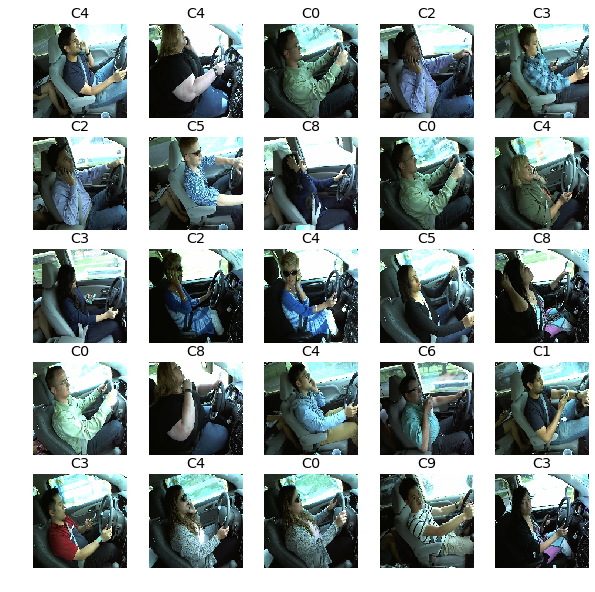

In [0]:
# Exibe imagens do primeiro lote de imagens de treinamento
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Definindo o Modelo

In [0]:
def create_model(train_base_model=False):
    """Cria o modelo e todas as suas camadas"""
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

    # Camada base de convolução, MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE, include_top=False,
        weights='imagenet')
    
    # Define se a classe será treinada junto com as outras camadas
    base_model.trainable = train_base_model

    # Define a camada que converterá a saída das camadas de convolução
    # em um vetor de uma dimensão
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # Definindo a camada de previsão, fully connected layer
    prediction_layer = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='softmax')
    ]) 
    
    # Ligando as camadas do modelo
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])
    
    return model

In [0]:
def compile_model(model, learning_rate=0.001):
    """Definição das configurações de treinamento do modelo"""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [0]:
# Definindo o modelo
with strategy.scope():
    train_ds = train_data_gen
    valid_ds = validation_data_gen
    test_ds = test_data_gen
    if tpu:
        train_ds = tf.data.TFRecordDataset.from_generator(lambda: train_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        valid_ds = tf.data.TFRecordDataset.from_generator(lambda: validation_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        test_ds = tf.data.TFRecordDataset.from_generator(lambda: test_data_gen, output_types=(tf.float32, ), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3],))
        
    model = create_model()
    compile_model(model)

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
# Exibe os detalhes do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                362122    
Total params: 2,620,106
Trainable params: 362,122
Non-trainable params: 2,257,984
_________________________________________________________________


## Avaliando acurácia inicial do Modelo

In [0]:
loss0,accuracy0 = model.evaluate(valid_ds, steps=None)

18/18 [==============================] - 35s 2s/step - loss: 2.2992 - accuracy: 0.1118


## Treinando o Modelo

In [0]:
epochs = 15
# Treinando o modelo
history_1 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/15
71/71 [==============================] - 153s 2s/step - loss: 2.1888 - accuracy: 0.2627 - val_loss: 2.1920 - val_accuracy: 0.2524
Epoch 2/15
71/71 [==============================] - 119s 2s/step - loss: 1.9713 - accuracy: 0.4976 - val_loss: 2.1452 - val_accuracy: 0.3095
Epoch 3/15
71/71 [==============================] - 119s 2s/step - loss: 1.8842 - accuracy: 0.5850 - val_loss: 2.1553 - val_accuracy: 0.2961
Epoch 4/15
71/71 [==============================] - 119s 2s/step - loss: 1.8097 - accuracy: 0.6593 - val_loss: 2.2219 - val_accuracy: 0.2332
Epoch 5/15
71/71 [==============================] - 118s 2s/step - loss: 1.7549 - accuracy: 0.7144 - val_loss: 2.1646 - val_accuracy: 0.2850
Epoch 6/15
71/71 [==============================] - 118s 2s/step - loss: 1.7176 - accuracy: 0.7529 - val_loss: 2.1624 - val_accuracy: 0.2915
Epoch 7/15
71/71 [==============================] - 119s 2s/step - loss: 1.6910 - accuracy: 0.7762 - val_loss: 2

In [0]:
epochs = 10

# Recompilando o modelo para ajustar o learning rate
compile_model(model, learning_rate=0.0001)
# Treinando o modelo
history_2 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/10
71/71 [==============================] - 121s 2s/step - loss: 1.5682 - accuracy: 0.8973 - val_loss: 2.1717 - val_accuracy: 0.2774
Epoch 2/10
71/71 [==============================] - 137s 2s/step - loss: 1.5691 - accuracy: 0.8975 - val_loss: 2.1728 - val_accuracy: 0.2781
Epoch 3/10
71/71 [==============================] - 118s 2s/step - loss: 1.5635 - accuracy: 0.9005 - val_loss: 2.1711 - val_accuracy: 0.2803
Epoch 4/10
71/71 [==============================] - 118s 2s/step - loss: 1.5622 - accuracy: 0.9019 - val_loss: 2.1685 - val_accuracy: 0.2836
Epoch 5/10
71/71 [==============================] - 118s 2s/step - loss: 1.5601 - accuracy: 0.9053 - val_loss: 2.1628 - val_accuracy: 0.2886
Epoch 6/10
71/71 [==============================] - 118s 2s/step - loss: 1.5601 - accuracy: 0.9040 - val_loss: 2.1689 - val_accuracy: 0.2819
Epoch 7/10
71/71 [==============================] - 119s 2s/step - loss: 1.5619 - accuracy: 0.9041 - val_loss: 2

In [0]:
epochs = 50

# Habilitando o primeiro conjuto de layers de 
# convolução (modelo pré-treinado) para o treinamento
model.layers[0].trainable = True
# Recompilando o modelo para ajustar o learning rate
compile_model(model, learning_rate=0.0001)
# Treinando o modelo
history_3 = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Train for 71 steps, validate for 18 steps
Epoch 1/50
71/71 [==============================] - 138s 2s/step - loss: 1.5380 - accuracy: 0.9254 - val_loss: 2.0468 - val_accuracy: 0.4039
Epoch 2/50
71/71 [==============================] - 132s 2s/step - loss: 1.5005 - accuracy: 0.9633 - val_loss: 1.9318 - val_accuracy: 0.5278
Epoch 3/50
71/71 [==============================] - 132s 2s/step - loss: 1.4866 - accuracy: 0.9753 - val_loss: 1.8900 - val_accuracy: 0.5662
Epoch 4/50
71/71 [==============================] - 133s 2s/step - loss: 1.4779 - accuracy: 0.9836 - val_loss: 1.7634 - val_accuracy: 0.6985
Epoch 5/50
71/71 [==============================] - 132s 2s/step - loss: 1.4736 - accuracy: 0.9876 - val_loss: 1.7506 - val_accuracy: 0.7090
Epoch 6/50
71/71 [==============================] - 131s 2s/step - loss: 1.4734 - accuracy: 0.9884 - val_loss: 1.6756 - val_accuracy: 0.7849
Epoch 7/50
71/71 [==============================] - 133s 2s/step - loss: 1.4702 - accuracy: 0.9913 - val_loss: 1

## Salvando o Modelo

In [0]:
model.save(os.path.join(root_output_local, 'model_v2.h5'))

## Carregando o Modelo

In [0]:
new_model = tf.keras.models.load_model(os.path.join(root_output_local, 'model_v2.h5'))

## Avaliando o modelo treinado

In [0]:
loss1, accuracy1 = new_model.evaluate(valid_ds, steps=None)

18/18 [==============================] - 25s 1s/step - loss: 1.4697 - accuracy: 0.9911


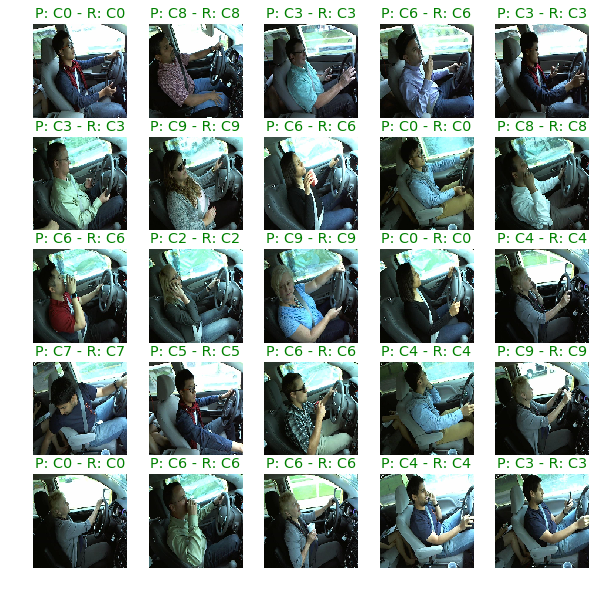

In [0]:
# Obtendo uma amostra (batch) dos dados de validação
image_batch, label_batch = next(valid_ds)
# Utilizando o modelo para classificar a amostra
predicted_labels = new_model.predict_classes(image_batch)
# Exibindo 25 exemplos da classificação realizada
show_batch(image_batch, label_batch, predicted_labels)

### Avaliando desempenho em relação a cada classe

In [0]:
predict_classes = new_model.predict_classes(validation_no_shuffe, batch_size=None)

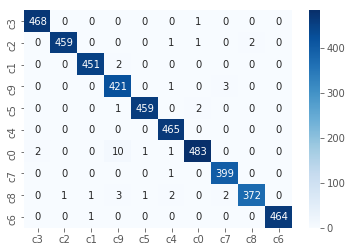

In [0]:
sns.heatmap(tf.math.confusion_matrix(validation_no_shuffe.classes, predict_classes), annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES);

In [0]:
result = pd.DataFrame(
    {'real_label': map(lambda x: CLASS_NAMES[x], validation_no_shuffe.classes), 
     'prediction': map(lambda x: CLASS_NAMES[x], predict_classes), 
     'correct_prediction': validation_no_shuffe.classes == predict_classes})
result.to_parquet('validation_result.parquet')
result.head()

,real_label,prediction,correct_prediction
0,c3,c3,True
1,c3,c3,True
2,c3,c3,True
3,c3,c3,True
4,c3,c3,True


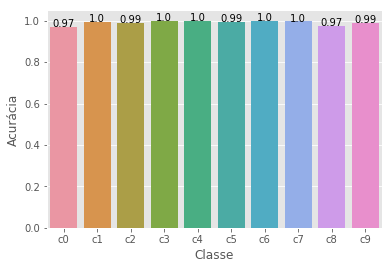

In [0]:
acc_per_class = result.groupby('real_label').mean().reset_index()
ax = sns.barplot(x="real_label", y="correct_prediction", data=acc_per_class);
ax.set_xlabel('Classe')
ax.set_ylabel('Acurácia')

for index, row in acc_per_class.iterrows():
    ax.text(row.name,row.correct_prediction, round(row.correct_prediction,2), color='black', ha="center")

### Avaliando desempenho nos dados de teste (visualmente)

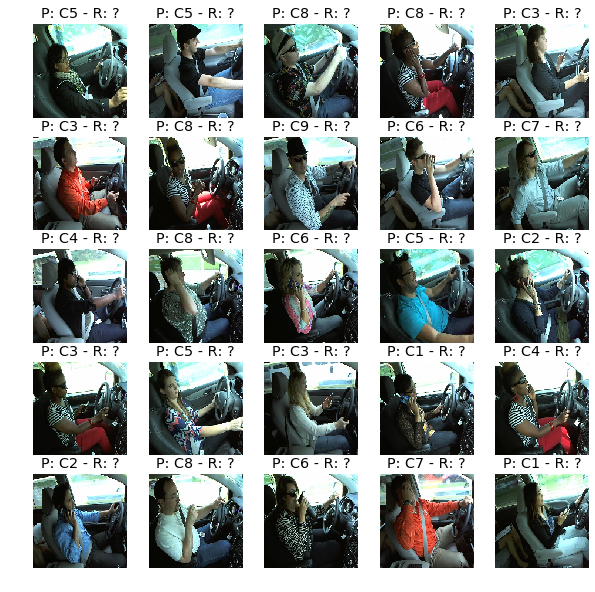

In [0]:
# Obtendo uma amostra (batch) dos dados de teste
image_batch = next(test_ds)
# Utilizando o modelo para classificar a amostra dos dados de teste
predicted_labels = new_model.predict_classes(image_batch)
# Exibindo 25 exemplos da classificação realizada
show_batch(image_batch, predict_labels=predicted_labels)

## Analisando a performance durante o treinamento

In [0]:
histories = [history_1, history_2, history_3]

history_df = pd.concat([pd.DataFrame(h.history) for h in histories], ignore_index=True)

### Salvando historico de treinamento

In [0]:
history_df.to_parquet(os.path.join(root_output_local, 'history.parquet'))

### Carregando histórico de treinamento

In [0]:
history_df = pd.read_parquet(os.path.join(root_output_local, 'history.parquet'))

history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.188131,0.262721,2.191971,0.252399
1,1.969230,0.497576,2.145233,0.309529
2,1.882782,0.585019,2.155330,0.296139
3,1.809522,0.659310,2.221912,0.233207
4,1.753712,0.714429,2.164605,0.284981


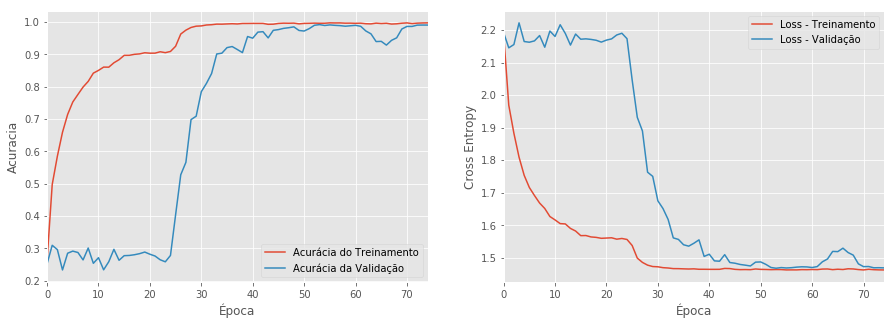

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

history_df.accuracy.plot(ax=ax1, label='Acurácia do Treinamento')
history_df.val_accuracy.plot(ax=ax1, label='Acurácia da Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Acuracia')
ax1.legend()

history_df.loss.plot(ax=ax2, label='Loss - Treinamento')
history_df.val_loss.plot(ax=ax2, label='Loss - Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Cross Entropy')
ax2.legend()

fig.show()

## Criando arquivo de submissão do Kaggle

In [0]:
# Obtendo os valores de probabilidade por classe
proba_test = new_model.predict_proba(test_data_gen, batch_size=None)

In [0]:
# Criação do Dataframe com os resultados
output_kaggle = pd.DataFrame(proba_test, 
                             columns=CLASS_NAMES, 
                             index=test_data_gen.filenames)

# Ordenando colunas e ajustando o índice
output_kaggle = (output_kaggle[output_kaggle.columns.sort_values()]
                 .reset_index().rename(columns={'index': 'img'}))

# Ajustando coluna para identificação das imagens
output_kaggle['img'] = output_kaggle.img.str.split('/').apply(lambda x: x[-1])

In [0]:
output_kaggle.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,1.505019e-30,6.381341e-30,4.699787e-35,6.741732e-24,2.393920e-30,1.000000e+00,1.189201e-31,8.329408e-31,3.981544e-27,2.881033e-27
1,img_10.jpg,2.255374e-23,7.685093e-25,3.307460e-26,3.626906e-22,3.521033e-23,1.000000e+00,7.565550e-23,9.107333e-22,1.429820e-21,3.635409e-23
2,img_100.jpg,1.096826e-01,6.158369e-02,2.008766e-06,1.657336e-03,7.180734e-06,4.662367e-05,2.047121e-03,4.297115e-05,8.184505e-01,6.480010e-03
3,img_1000.jpg,3.755512e-27,2.644078e-26,1.010526e-23,4.151064e-26,1.155110e-22,3.220804e-24,9.297842e-22,8.985068e-23,1.000000e+00,4.259914e-23
4,img_100000.jpg,3.224771e-27,3.493342e-29,4.792361e-32,1.000000e+00,3.968820e-20,1.335907e-25,1.858378e-32,2.565566e-33,3.760314e-27,1.128806e-26


In [0]:
# Salvando o arquivo de submissão
output_kaggle.to_csv('submission.csv', index=False)